# Machine Learning Project - Image Classification Challenge

In this notebook we report all our experiments and results for the image classification challenge.

We organized this notebook in the following way: for each different type of model we subdivided the analisys in three main parts: 
 - **Data preprocessing**;
 - **Model estimation**: in this part we experiment and find the best model with the best hyperparameters;
 - **Model evaluation**: here, we  see how well our model performs on the validation set, and then give our predictions on the test set.
 
**Important note**: a lot of the cells in this notebook, especially the ones where we perform grid searches, require a **lot of time to run**, some even several hours. We indicated those cells with a <font color='orange'> YELLOW TEXT IN CAPS LOCK <font color='black'>. To run the notebook in a reasonable amount of time, we saved to disk the results of the most time consuming computations, and we made it possible to load them from disk. We provided a folder with all the saved models (or .csv files containing results for grid searches), which is supposed to be named "data" and to be placed in the same working directory of this notebook.
    
We didn't include a lot of the original models and Python objects containing the results for our grid searches, since those files are really heavy (several GB of files). Instead, we saved those results inside .csv files.
    
However, the original .sav files can be found at the following shared Drive folder: https://drive.google.com/folderview?id=15hBJWIDkKbg6a3-W4EzhNyUeWkBTEajx

In [1]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

##################################################
# Set current directory
##################################################

currentDirectory=os.getcwd()#current working directory

DATA_BASE_FOLDER = 'data'

# Dataset

The dataset contains 50k train + 10k validation images of 10 different categories ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot').

Each image is a 28x28 grayscale, and for simplicity here is flattened into a 784 dimensional vector.

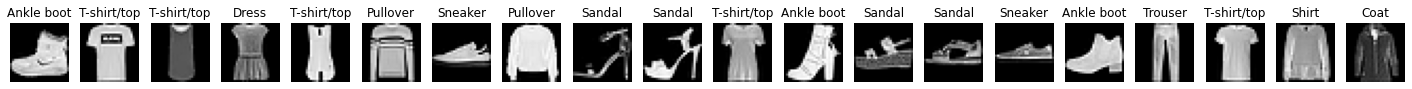

In [2]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [3]:
x_train.shape

(50000, 784)

# Overview

We are going to apply five different models:
- Logistic Regression
- KNN
- Random Forest
- Support Vector Machines
- Convolutional Neural Networks

For each of them we apply the needed pre-processing of data and evaluate their performances.


# Model - Logistic Regression

### Pre-processing
Since we are going to apply regularization, it's advisible to rescale the data. 

In [4]:
x_train_scaled=x_train/255
x_valid_scaled=x_valid/255
x_test_scaled=x_test/255

In order to fit the data in a reasonable amount of time, we take 20% of observations in the train set to fit the model.

Since classes are almost balanced, we just take the first 10000 observations.

In [5]:
x_train_reduced=x_train_scaled[0:10000]
y_train_reduced=y_train[0:10000]

### Model estimation

In [6]:
from sklearn.linear_model import LogisticRegression

In order to maximize the performance of the model, we have to find the optimal values for the hyperparameters:
- penalty: $l_1$ (Lasso) or $l_2$ (Ridge) 
- C: the inverse of regularization hyperparameter $\lambda$, so $C=\frac{1}{\lambda}$
- solver: we choose the only two algorithms which support both penalties. Note that, the scikit learn module implements the "one vs rest" scheme when using the "liblinear" solver, and implements Softmax Regression when using the "saga" solver. In this way, we are also testing the two different kinds of generalization of Logistic Regression for multiclass, and assess which one performs best.

This can be done using the **grid search** technique.

First define the grid over which the search has to be performed:

In [7]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga']
param_grid = dict(penalty=penalty,
                  C=C,
                  solver=solver)

Define the Cross Validation (CV) strategy: 
- compute the frequency of each class
- shuffle the training set
- split it in 5 folds respecting the frequency of each class within each fold
- set a random seed for replicability

In [8]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

We define the model and fit the grid search:

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
logreg = LogisticRegression()

grid_search_logistic = GridSearchCV(estimator=logreg,
                                    param_grid=param_grid,
                                    cv=cv,
                                    n_jobs=-1)
grid_search_logistic.fit(x_train_reduced, y_train_reduced)

print(grid_search_logistic.best_params_)
print("Cross Validation Accuracy: %f" % grid_search_logistic.best_score_)

In [9]:
#load the grid search
grid_search_logistic = joblib.load('data/grid_search_Logistic.sav')

D:\Programmi\Anaconda\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Programmi\Anaconda\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


The results of the grid search are:

In [10]:
results_grid_search_logistic = pd.DataFrame(grid_search_logistic.cv_results_)
results_grid_search_logistic=results_grid_search_logistic[['params','mean_test_score','rank_test_score']]
results_grid_search_logistic.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_logistic.head()

,params,mean_test_score,rank_test_score
15,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.8430,1
17,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.8405,2
14,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.8403,3
16,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.8365,4
19,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.8363,5


### Train the model with the optimal hyperparameters on the full Training Set
We train the model with optimal hyperparameters found in the reduced training set, on the full train set.

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [32]:
logreg = LogisticRegression(penalty='l2',
                            C=0.1,
                            solver='saga',
                            max_iter=1000)
logreg.fit(x_train_scaled,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# to load the model from disk
logreg = joblib.load('data/LogisticRegr.sav')

D:\Programmi\Anaconda\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Model evaluation

In [12]:
logreg.score(x_valid_scaled, y_valid)

0.8559

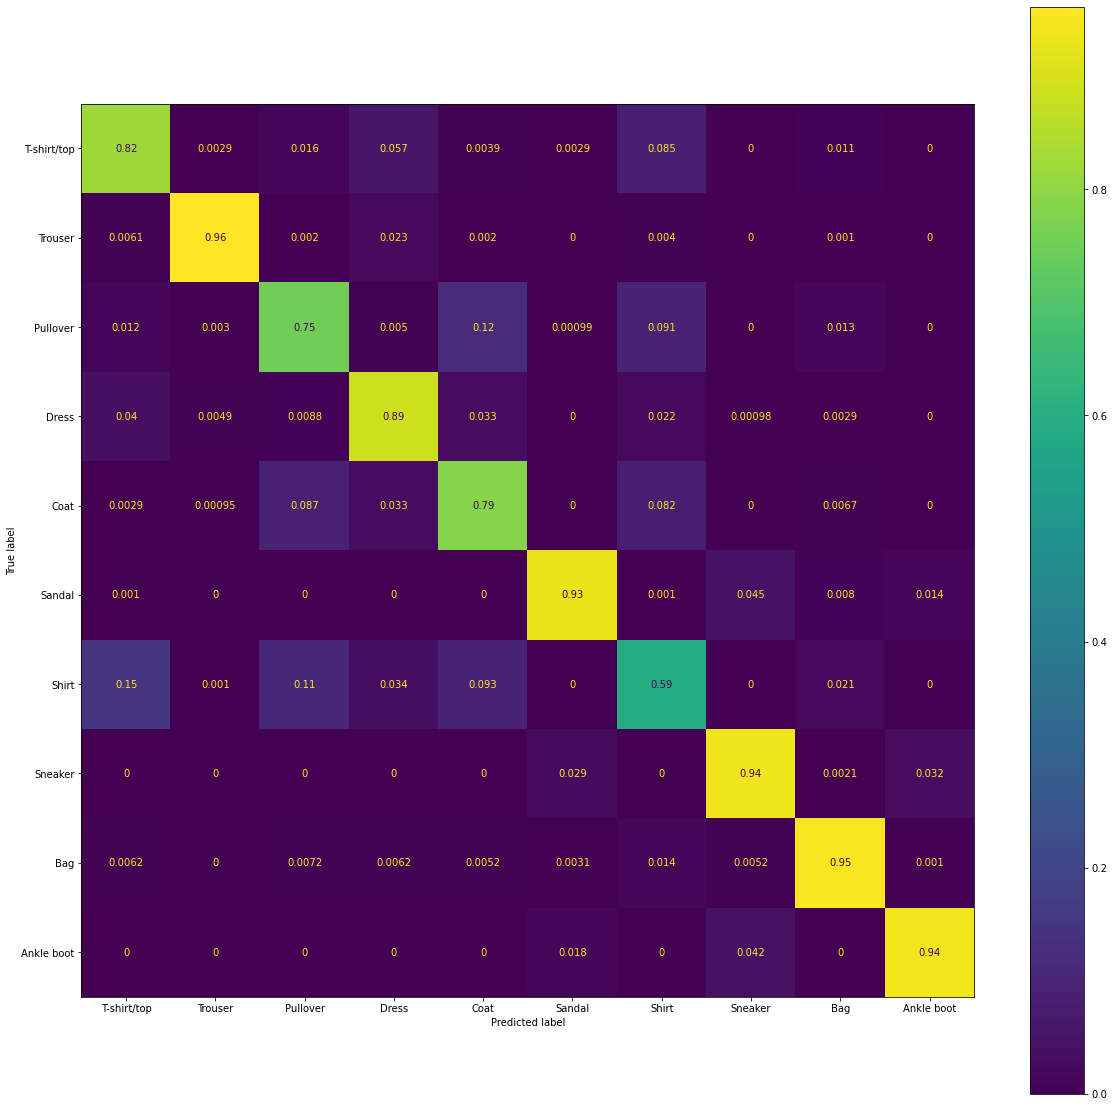

In [13]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(logreg, x_valid_scaled, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [14]:
y_pred_logreg=logreg.predict(x_test_scaled)

In [15]:
# save that on a .csv file for the submission
predictions_logreg_file=pd.DataFrame(y_pred_logreg)
predictions_logreg_file = predictions_logreg_file.to_csv('data/y_predictions_logreg.csv', sep=',',index=False)

# Model - KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

### Pre-processing
For better numerical stability is advisible to divide by 255 each feature.


In [19]:
x_train_scaled=x_train/255
x_valid_scaled=x_valid/255
x_test_scaled=x_test/255

### Model estimation
We use grid search to find the best value of k (='n_neighbors'). 

We do not look for the best value of $p$ in the $L_p$ metrics, because theorical 
results have prooved that the meaningfulness of the $L_p$ norm worsens faster within 
increasing dimensionality for higher values of $p$. Thus, for a given problem with a 
fixed (high) value for the dimensionality $d$, it is preferable to use lower values of $p$.
This means that the $L_1$ distance metric (Manhattan distance metric) is the most preferable 
for high dimensional applications, followed by the Euclidean metric ($L_2$).  
For reference see:

- Charu C. Aggarwal, Alexander Hinneburg, Daniel A. Keim, "On the Surprising Behavior of    Distance Metrics in High Dimensional Space"
- Kevin Beyer, Jonathan Goldstein, Raghu Ramakrishnan, Uri Shaft, "When Is 'Nearest Neighbor' Meaningful?"

In order to maximize the performance of the model, we have to find the optimal values for the hyperparameter:
- n_neighbors: the number of observations defining the neighborhood of the target observation 

This can be done using the **grid search** technique.

First define the grid over which the search has to be performed:

In [20]:
# Define the grid for the grid search
param_grid = {'n_neighbors': list(range(1,21))}
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}


Define the Cross Validation (CV) strategy: 
- compute the frequency of each class
- shuffle the training set
- split it in 5 folds respecting the frequency of each class within each fold
- set a random seed for replicability

In [21]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

We define the model and fit the grid search:

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
# grid search with 5 fold cross validation
grid_search_knn = GridSearchCV(KNeighborsClassifier(p=1),
                           param_grid, 
                           cv=cv,
                           n_jobs=-1)
grid_search_knn.fit(x_train_scaled, y_train)
print(grid_search_knn.best_params_)
print("Cross Validation Accuracy: %f" % grid_search_knn.best_score_)

The size of the full output file (.sav) is too big to be sent or uploaded, so we converted it in a Dataframe and then we saved it as a .csv file: 

In [22]:
#load the grid search results:
results_grid_search_knn=pd.read_csv('data/results_grid_search_knn.csv')
results_grid_search_knn.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_knn.head()

,params,mean_test_score,rank_test_score
4,{'n_neighbors': 5},0.85958,1
5,{'n_neighbors': 6},0.85946,2
3,{'n_neighbors': 4},0.85858,3
7,{'n_neighbors': 8},0.85838,4
6,{'n_neighbors': 7},0.85820,5


### Train the model with the optimal hyperparameters on the full Training Set
We train the model with optimal hyperparameters in the full training set.

In [23]:
knn_5 =KNeighborsClassifier(n_neighbors=5, p=1)
knn_5.fit(x_train_scaled,y_train)

KNeighborsClassifier(p=1)

### Model evaluation

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE RESULT OF THE ACCURACY IN THE VALIDATION SET**) 

In [24]:
# Use this function to evaluate your model
y_pred=knn_5.predict(x_valid_scaled)
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.
valid_set_accuracy=accuracy(y_pred,y_valid)
valid_set_accuracy

0.857

In [26]:
# to load the score in the validation set from disk
knn_5_score = pd.read_csv('data/5nn_score.csv')
knn_5_score

,knn_score
0,0.857


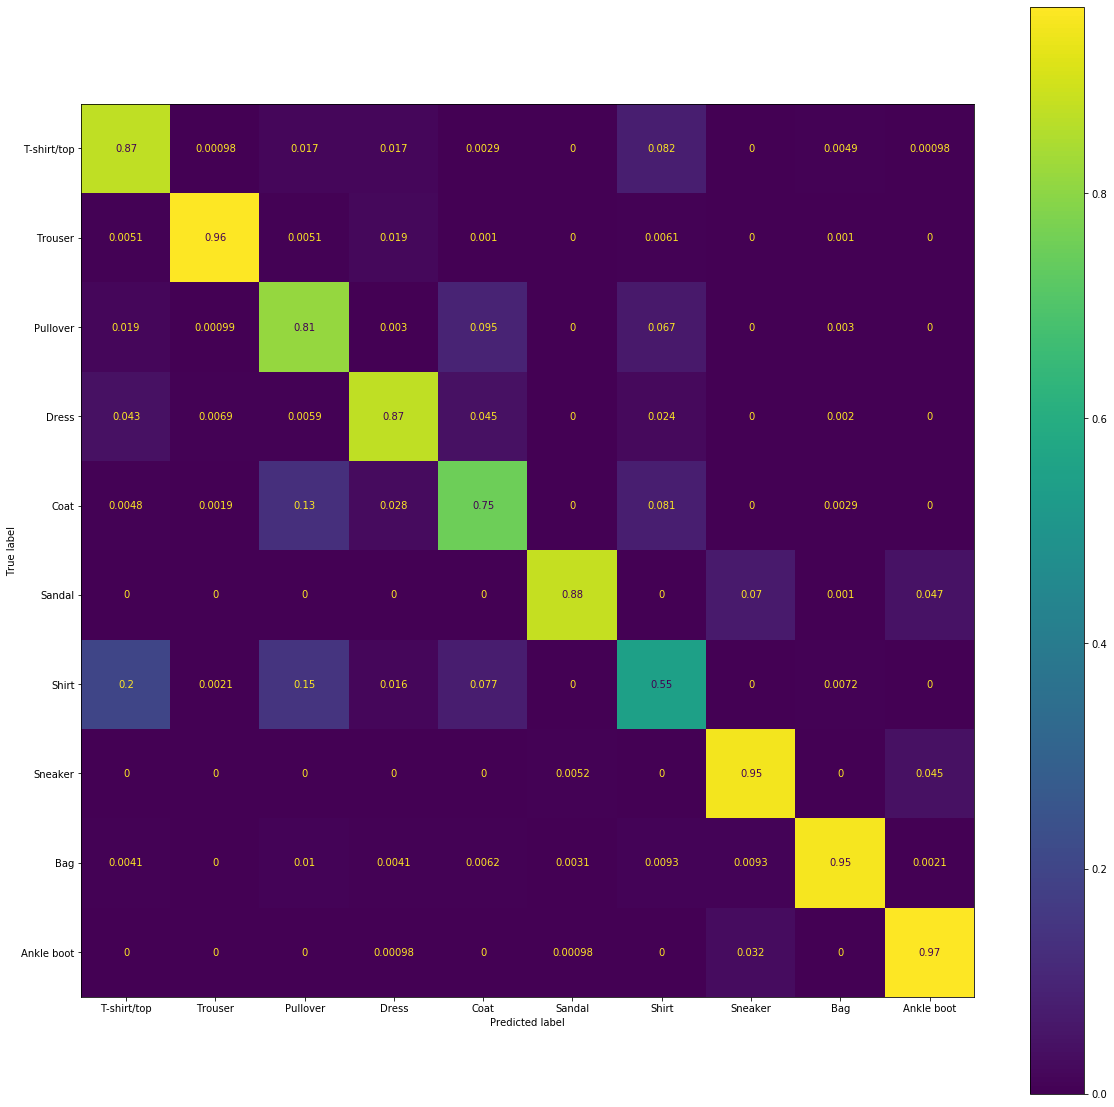

In [134]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(knn_5, x_valid_scaled, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

## Test with Euclidean Distance
To check if the Manhattan metric yields better results than the Euclidean we make the same grid search using the $L_2$ metric. 

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
# STRATIFIED KFOLD + GRID SEARCH (EUCLIDEAN METRIC (L2))
# use grid search to find the best value of k

# with p=2 we are using the euclidean Distance (default parameter)
grid_search_euclidean = GridSearchCV(
                                        KNeighborsClassifier(p=2), 
                                        param_grid, 
                                        cv=cv, 
                                        n_jobs=-1)
grid_search_euclidean.fit(x_train_norm, y_train)

The size of the full output file (.sav) is too big to be sent or uploaded, so we converted it in a Dataframe and then we saved it as a .csv file: 

In [27]:
#load the grid search results:
results_grid_search_knn=pd.read_csv('data/results_grid_search_euclidean.csv')
results_grid_search_knn.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_knn.head()

,params,mean_test_score,rank_test_score
5,{'n_neighbors': 6},0.85258,1
3,{'n_neighbors': 4},0.85246,2
4,{'n_neighbors': 5},0.85200,3
7,{'n_neighbors': 8},0.85170,4
6,{'n_neighbors': 7},0.85098,5


### Train the model with the optimal hyperparameters on the full Training Set
We train the model with optimal hyperparameters in the full training set.

In [28]:
knn_6 =KNeighborsClassifier(n_neighbors=6, p=2)
knn_6.fit(x_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=6)

### Model evaluation

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE RESULT OF THE ACCURACY IN THE VALIDATION SET**) 

In [135]:
# Use this function to evaluate your model
y_pred=knn_6.predict(x_valid_scaled)
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.
valid_set_accuracy=accuracy(y_pred,y_valid)
valid_set_accuracy

0.8547

In [29]:
# to load the score in the validation set from disk
knn_6_score = pd.read_csv('data/6nn_score.csv')
knn_6_score

,knn_score
0,0.8547


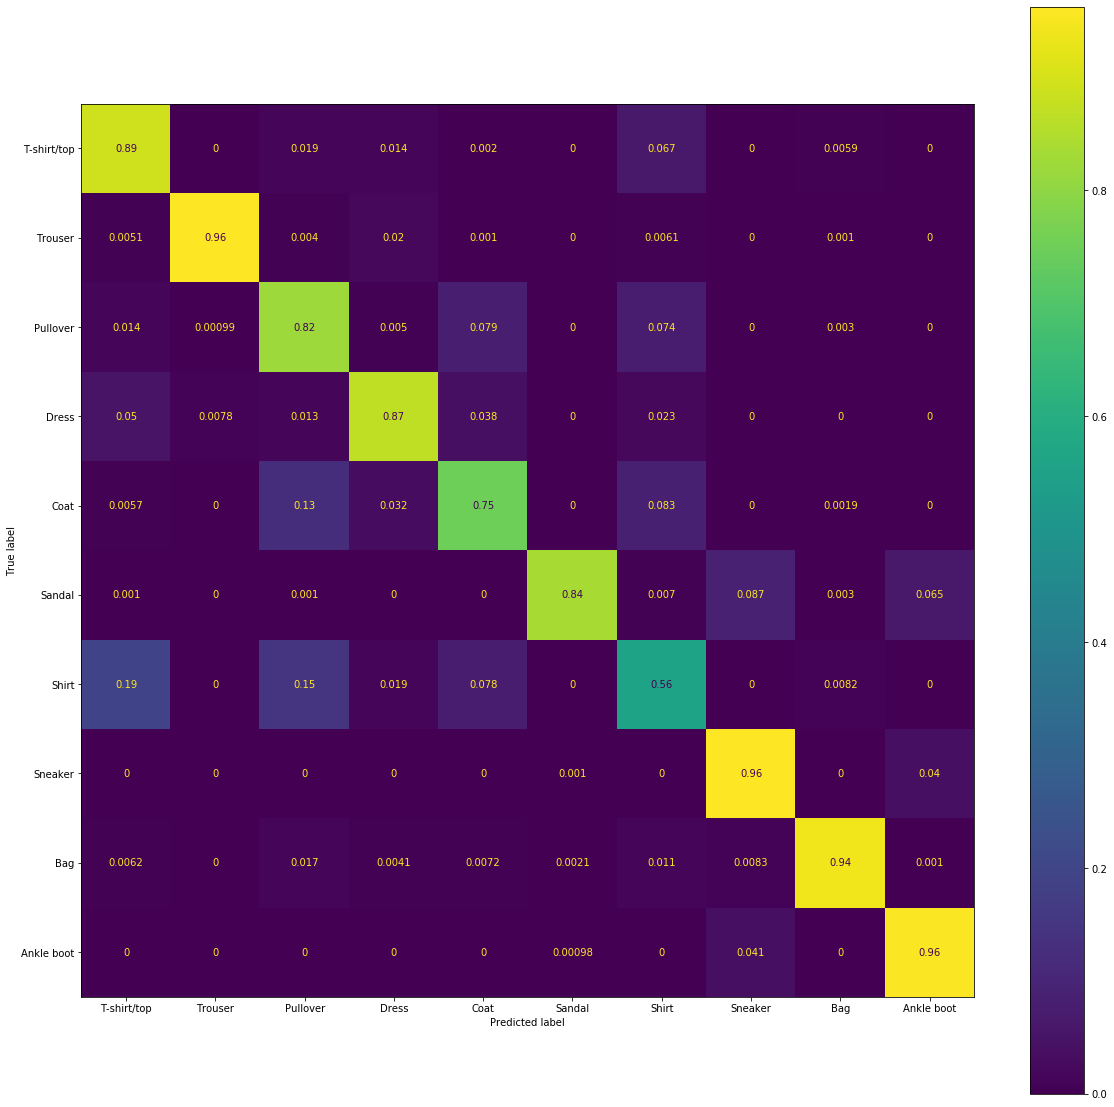

In [136]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(knn_6, x_valid_scaled, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

The empirical check has shown the validity of the theoretical result stated and the beginning: 

the best metric is $L_1$

Hence in the following we proceed in our analysis using the mode **knn_5**.

### Dimensionaly reduction using PCA
To recognize an item, we don't look at the single pixel, but at the overall image.
So extracting Principal Components (PCs) and using them to identify different items 
is an attempt to mimic how humans identify items.
Using the optimal value of $k$ found before, we look how much varies the accuracy
in train and valid set increasing the n° of PCs used to approximate each sample.
Around 20 PCs, the Accuracy curve starts being flat, meaning that adding further 
PCs increases just a little the performance, so it's not worth to add them.

In [30]:
from sklearn.decomposition import PCA

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT TWO CELLS AND LOAD THE SAVED IMAGE**) 

In [ ]:
cv_accuracy = []
PC_number = range(1, 100)

#build a single big PCA
pca = PCA(n_components=100, whiten=True, random_state=0).fit(x_train_scaled)
x_train_pca = pca.transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)

for i in PC_number:
    x_train_pca_aux = x_train_pca[:, :i]
    x_valid_pca_aux = x_valid_pca[:, :i]
    knn = KNeighborsClassifier(n_neighbors=5,p=1)
    knn.fit(x_train_pca_aux, y_train)
    # record generalization accuracy
    cv_accuracy.append(knn.score(x_valid_pca_aux, y_valid.reshape(-1,1)))

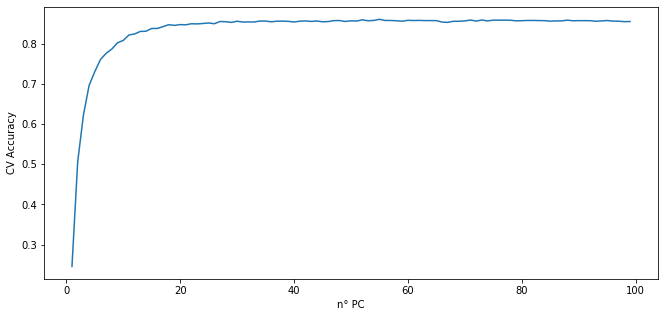

In [151]:
fig, axes = plt.subplots(1,1, figsize=(11,5))
axes.set_ylabel("CV Accuracy")
axes.set_xlabel("n° PC")

_ = axes.plot(PC_number, cv_accuracy, label="valid accuracy")

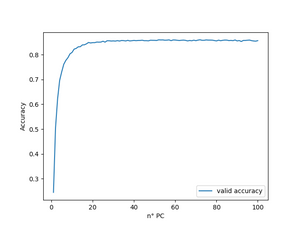

In [31]:
#load the figure
import matplotlib.image as mpimg
img = mpimg.imread('data/Accuracy VS number_PCs.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

We now try a similar approach, but at each iteration we perform a grid search in order to be sure that the best parameter is chosen at every step. Since it's a really long process, we make this experiment just on 20000 samples and not all the TS

In [33]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 20000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:size]/255
x_test_sc =x_test/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:size]

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE SAVED IMAGE**) 

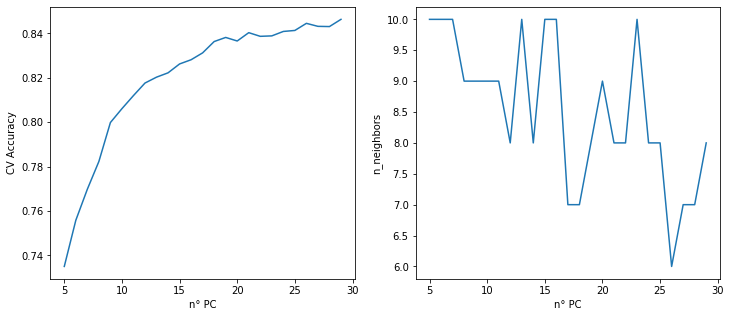

In [38]:
# WE PLOT the cv accuracy of KNN (for every model we perform grid search for the best parameter)
# w.r.t. the number of principal components

#training_accuracy = []
cv_accuracy = []
best_params= []
PC_number = range(5, 30)

#build a single big PCA
pca = PCA(n_components=50, whiten=True, random_state=0).fit(x_train_sc)
x_train_pca = pca.transform(x_train_sc)
x_valid_pca = pca.transform(x_valid_sc)

for i in PC_number:
    x_train_pca_aux = x_train_pca[:, :i]
    x_valid_pca_aux = x_valid_pca[:, :i]
    grid_search_aux = GridSearchCV(KNeighborsClassifier(p=1), param_grid, cv=cv, n_jobs=-1)
    grid_search_aux.fit(x_train_pca_aux, y_train_sc)
    
    # record generalization accuracy
    cv_accuracy.append(grid_search_aux.best_score_)
    best_params.append(grid_search_aux.best_params_["n_neighbors"])

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].set_ylabel("CV Accuracy")
axes[0].set_xlabel("n° PC")

axes[1].set_ylabel("n_neighbors")
axes[1].set_xlabel("n° PC")

_ = axes[0].plot(PC_number, cv_accuracy, label="valid accuracy")
_ = axes[1].plot(PC_number, best_params)


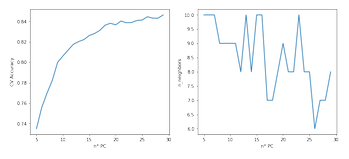

In [32]:
#load the figure
import matplotlib.image as mpimg
img = mpimg.imread('data/img pc.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

So as we can see we don't obtain much better results in terms of cv accuracy.

Observing the plots, the accuracy growth becomes flat approx. after the first 20 PCs. 
So to have an easier model, with less features, we decide to use 20 PCs.

We compute the first 20 PCs for train set and validation set.

In [33]:
pca = PCA(n_components=20, whiten=True, random_state=0).fit(x_train_scaled)
x_train_pca = pca.transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

We train the model with the optimal hyperparameter $k^*=5$ on the full training set.

In [34]:
knn_5_pca = KNeighborsClassifier(n_neighbors=5,p=1)
knn_5_pca.fit(x_train_pca, y_train)

KNeighborsClassifier(p=1)

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE SAVED IMAGE**) 

pca.components_.shape: (100, 784)


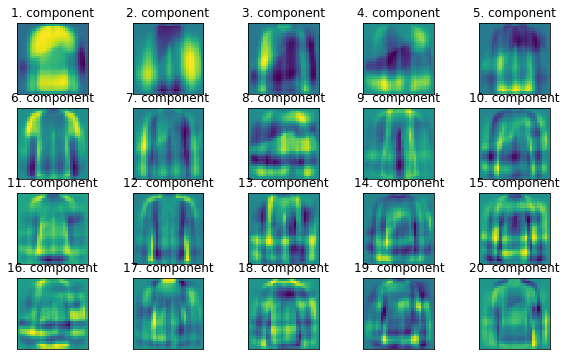

In [157]:
#plot the PCs
print("pca.components_.shape: {}".format(pca.components_.shape))
fix, axes = plt.subplots(4, 5, figsize=(10, 6),subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape((28,28)),cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))
plt.savefig('first 20 PCs.png')

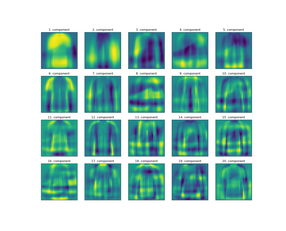

In [35]:
#load the figure
img = mpimg.imread('data/first 20 PCs.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

### Model evaluation

The perfomance in the validation set is:

In [36]:
knn_5_pca.score(x_valid_pca, y_valid.reshape(-1,1))

0.8482

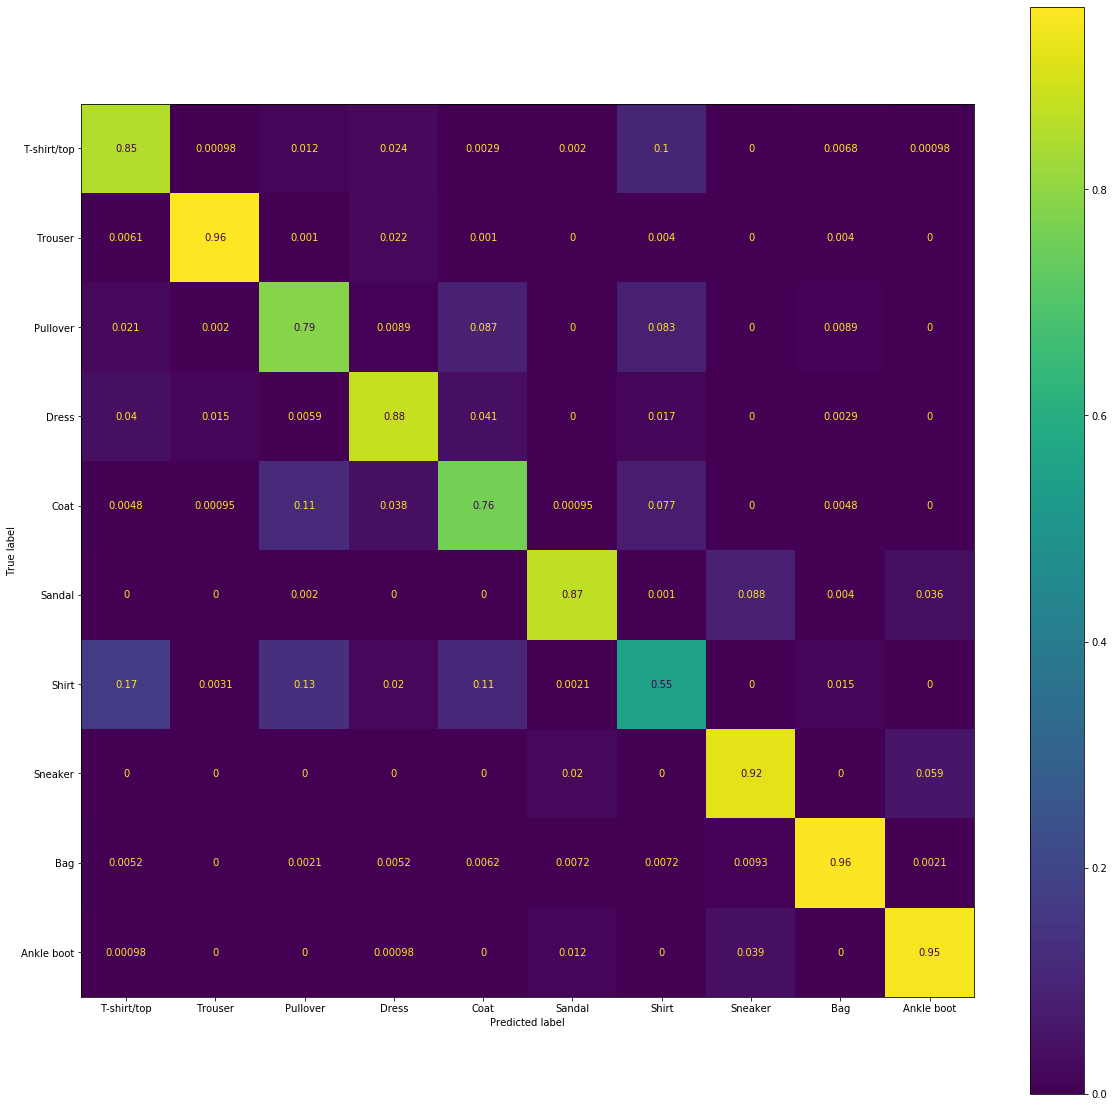

In [104]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(knn_5_pca, x_valid_pca, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP) 
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown labels in the test set: 

In [105]:
y_pred_knn=knn_5_pca.predict(x_test_pca)

In [106]:
# save that on a .csv file for the submission
predictions_knn_file=pd.DataFrame(y_pred_knn)
predictions_knn_file =predictions_knn_file.to_csv('data/y_predictions_5nn_pca.csv', sep=',',index=False)

# Model - Random Forest

### Pre-processing

In [37]:
x_train_scaled=x_train/255
x_valid_scaled=x_valid/255
x_test_scaled=x_test/255

pca = PCA(n_components=20, whiten=True, random_state=0).fit(x_train_scaled)
x_train_pca = pca.transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

### Model estimation
Using PCA, we reduced the features' dimension from 784 to 20. Now, we want to apply
a 'Decision Tree' to classify the items using only the 20 PCs extracted before.

Choosing the parameter 'max_depth' high enough, it's possible to classify 
perfectly each class in the training set, reaching an accuracy of 100%. But
then the performance in the test set is going to be much smaller, due to overfitting.

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Here we guess a value for 'max_depth', with the following result:

In [39]:
tree = DecisionTreeClassifier(max_depth=15,random_state=0)
tree.fit(x_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(x_train_pca, y_train)))
print("Accuracy on validation set: {:.3f}".format(tree.score(x_valid_pca, y_valid)))

Accuracy on training set: 0.902
Accuracy on validation set: 0.783


To choose the optimal value of 'max_depth' it's needed a grid search. Anyway we don't investigate further the **Decision Tree** model, because we aim at a more robust result using an ensemble: **Random Forest**

A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount
of overfitting by averaging their results. 

**Important Note**: we are aware that, by using this kind of model over the features extracted via PCA, we are losing a very important advantage that Random Forest gives, which is the **interpretability** of the results (the principal components, are not features that we can interpret in a meaningful and intuitive way). Anyhow, we wanted to see how this kind of decision tree based model could perform on such a setting.

- 'n_estimators': number of trees to build (larger is always better. Averaging more trees will yield a more robust ensemble by reducing overfitting)
- 'max_features': number of randomly selected features among which the algo looks for the best one. It’s a good rule of thumb to use the default values: max_features=$\sqrt{n_{features}}$

In [40]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=15,
                                max_features=5, 
                                random_state=0,
                                n_jobs=-1)
forest.fit(x_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(x_train_pca, y_train)))
print("Accuracy on valid set: {:.3f}".format(forest.score(x_valid_pca, y_valid)))

Accuracy on training set: 0.949
Accuracy on valid set: 0.842


We use the grid search technique to find the best values of hyperparameters:
- 'max_depth'
- 'max_features'

In [41]:
# Define the grid for the grid search
param_grid = {'max_depth': list(range(1,21)),
              'max_features': list(range(1,21))}
# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
grid_search_forest = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                  random_state=0,
                                                  n_jobs=-1),
                           param_grid, cv=cv,n_jobs=-1)
grid_search_forest.fit(x_train_pca, y_train)

The size of the full output file (.sav) is too big to be sent or uploaded, so we converted it in a Dataframe and then we saved it as a .csv file: 

In [42]:
#load the grid search results:
results_grid_search_forest=pd.read_csv('data/results_grid_search_forest.csv')
results_grid_search_forest.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_forest.head()

,params,mean_test_score,rank_test_score
385,"{'max_depth': 20, 'max_features': 6}",0.85472,1
383,"{'max_depth': 20, 'max_features': 4}",0.85458,2
365,"{'max_depth': 19, 'max_features': 6}",0.85424,3
389,"{'max_depth': 20, 'max_features': 10}",0.85410,4
366,"{'max_depth': 19, 'max_features': 7}",0.85394,5


There is a problem: the optimal hyperparamer 'max_depth' $=20$ is a corner solution.
To be sure that does not exist a better model with higher depth, we expand
the grid search to values of 'max_depth' $\ge20$.

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
param_grid = {'max_depth': list(range(20,30)),
              'max_features': list(range(5,11))}
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
grid_search_forest = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                  random_state=0,
                                                  n_jobs=-1),
                           param_grid, cv=cv,n_jobs=-1)
grid_search_forest.fit(x_train_pca, y_train)

In [43]:
#load the grid search results:
results_grid_search_restricted_forest=pd.read_csv('data/results_grid_search_restricted_forest.csv')
results_grid_search_restricted_forest.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_restricted_forest.head()

,params,mean_test_score,rank_test_score
26,"{'max_depth': 24, 'max_features': 7}",0.85596,1
43,"{'max_depth': 27, 'max_features': 6}",0.85588,2
25,"{'max_depth': 24, 'max_features': 6}",0.85578,3
38,"{'max_depth': 26, 'max_features': 7}",0.85562,4
19,"{'max_depth': 23, 'max_features': 6}",0.85560,5


We train the model with optimal hyperparameters:

In [44]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=24,
                                max_features=7, 
                                random_state=0,
                                n_jobs=-1)
forest.fit(x_train_pca, y_train)

RandomForestClassifier(max_depth=24, max_features=7, n_jobs=-1, random_state=0)

### Model evaluation

In [45]:
# Use this function to evaluate your model
y_pred=forest.predict(x_valid_pca)
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.
valid_set_accuracy=accuracy(y_pred,y_valid)
valid_set_accuracy

0.8508

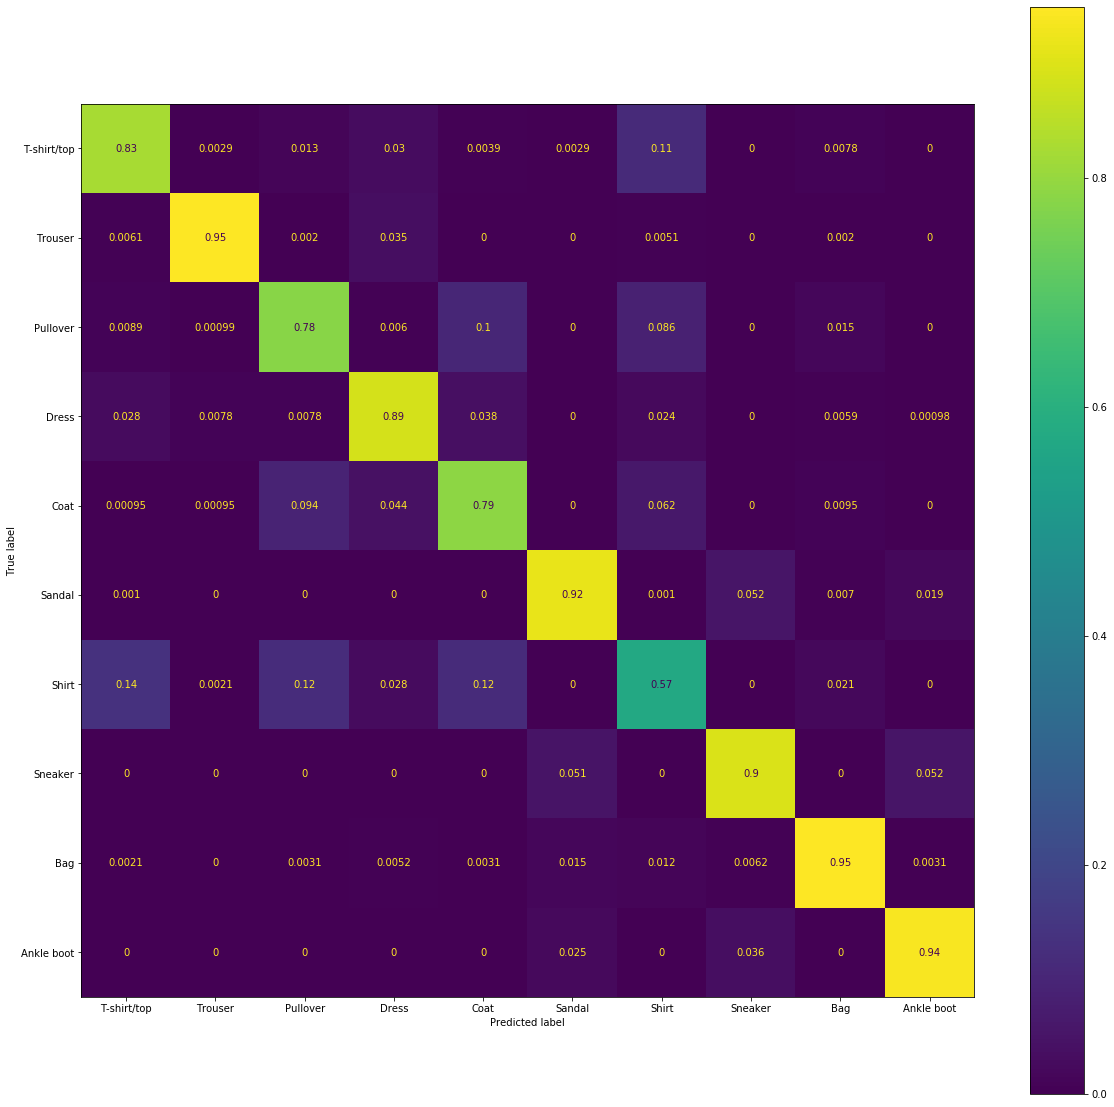

In [128]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(forest, x_valid_pca, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)  
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown labels in the test set: 

In [129]:
y_pred_forest=forest.predict(x_test_pca)

In [130]:
# save that on a .csv file for the submission
predictions_forest_file=pd.DataFrame(y_pred_forest)
predictions_forest_file =predictions_forest_file.to_csv('data/y_predictions_forest.csv', sep=',',index=False)

# Model - Convolutional Neural Network

Convolutional Neural Networks (CNNs) are a class of Neural Networks mainly specialized in image recognition tasks. The key idea that makes CNNs really good for image analysis is that, instead of preprocessing the data to derive features like textures and shapes, they take just the image's raw pixel data as input and "learn" how to extract these features during the training process, thanks to the convolution operation.

The most important elements of a CNN are the following:
 - **Convolutional** layers with a specified activation function. This is the core element of CNNs as they contain the learned kernels (weights), which extract features that distinguish different images from one another. Convolutional layers come with different hyperparameters that have to be specified:
  - Number of kernels;
  - **Activation function**: non linear activation functions typical of NNs.The most common choice for CNNs, for empirical reasons, seems to be the $ReLu$ activation function;
  - **Kernel size**: is the dimension of the sliding window over the input image. The choice of this hyperparameter has a huge impact: in fact, small kernel sizes are able to extract a much larger amount of information containing highly local features from the input.
  - **Stride**: how many pixels the kernel should be shifted at each time step when performing convolution. Clearly, a stride of one guarantees much rich feature extraction, but bigger output images.
  
 - A **MaxPooling** layer: pooling layers have the purpose of gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network. Max-Pooling is a common pooling operation that selects the pixel with the largest value in a sliding window of specified dimentions, with a specified stride;
 - A **Flatten Layer** : the flatten layer converts a three-dimensional layer (since we are working with tensors to handle color channels) into a one-dimensional vector to fit the input of a fully-connected layer for classification.

 - **Dense Output Layer**, with the **Softmax** activation function. The main role of the softmax operation is to convert the vector of scores into a vector of probabilities (that means, whose components sum up to 1).
 
 We implemented our models with the keras python module.
 

## Pre-processing

Like before, we scale the data for better numerical stability. Also, we add an additional dimension since keras models work with tensors.

In [46]:
#SET SIZE = size of training set to use. Use 50000 to use full TS, or smaller sizes just for testing purposes.
size = 50000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:int(size/5)]/255
x_test_sc =x_test/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:int(size/5)]

x_train_sc=x_train_sc.reshape(size,28,28,1)
x_valid_sc=x_valid_sc.reshape(int(size/5),28,28,1)

print("Size of x_train_sc is now: {}".format(x_train_sc.shape))
print("Size of x_valid_sc is now: {}".format(x_valid_sc.shape))

print("Size of y_train_sc is now: {}".format(y_train_sc.shape))
print("Size of y_valid_sc is now: {}".format(y_valid_sc.shape))

Size of x_train_sc is now: (50000, 28, 28, 1)
Size of x_valid_sc is now: (10000, 28, 28, 1)
Size of y_train_sc is now: (50000,)
Size of y_valid_sc is now: (10000,)


In [47]:
# Function to plot accuracy on TS and VS in same figure

def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['accuracy'], label = "Accuracy on TS")
    plt.plot(history.epoch,history.history['val_accuracy'], label = "Accuracy on VS")
    plt.legend()
    plt.title('Train and Validation Accuracies')

## Model estimation

Before finding the best model, we tried different architectures: we started with the simplest possible one, which is the following:
 - Single Convolutional Layer (with $ReLu$);
 - MaxPooling Layer;
 - Flatten Layer;
 - Dense Output Layer.
 
Specifically, we set here a kernel size of $(3,3)$, which should be the smallest size to capture the notion of left/right, up/down, center. Hopefully, with the smallest possible kernel size, the model will able to capture the biggest amount of features from our image data. We also choose 16 kernels as a starting point.

### First CNN

In [7]:
##### First Neural Network - One Convolutional layer (with pooling) and a single dense final layer ####

def model1(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(filters=16,
               kernel_size=(3, 3), 
               name='conv0', 
               padding='same', #'same' preserve the dimension of input through the convolutions
               activation='relu')(X_input) 
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='model1')

    return model

input_shape=(28,28,1)  
model1 = model1(input_shape)

model1.compile(optimizer = "adam", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31370     
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model1.fit(x = x_train_sc, y = y_train_sc, epochs = 20, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/20
391/391 [==============================] - 2s 5ms/step - loss: 0.6032 - accuracy: 0.8005 - val_loss: 0.4314 - val_accuracy: 0.8488
Epoch 2/20
391/391 [==============================] - 2s 4ms/step - loss: 0.3917 - accuracy: 0.8642 - val_loss: 0.3699 - val_accuracy: 0.8710
Epoch 3/20
391/391 [==============================] - 2s 4ms/step - loss: 0.3515 - accuracy: 0.8766 - val_loss: 0.3526 - val_accuracy: 0.8743
Epoch 4/20
391/391 [==============================] - 2s 4ms/step - loss: 0.3286 - accuracy: 0.8852 - val_loss: 0.3457 - val_accuracy: 0.8735
Epoch 5/20
391/391 [==============================] - 2s 4ms/step - loss: 0.3089 - accuracy: 0.8922 - val_loss: 0.3159 - val_accuracy: 0.8866
Epoch 6/20
391/391 [==============================] - 2s 4ms/step - loss: 0.2946 - accuracy: 0.8977 - val_loss: 0.3037 - val_accuracy: 0.8925
Epoch 7/20
391/391 [==============================] - 2s 4ms/step - loss: 0.2834 - accuracy: 0.9014 - val_loss: 0.3041 - val_accuracy: 0.8911
Epoch 

In [17]:
# We see the performances of the model
info = model1.evaluate(x_valid_sc, y_valid_sc, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal Accuracy on Validation Set: {}".format(info[0], info[1]))


Final Loss on Validation Set: 0.27064573764801025; 
Final Accuracy on Validation Set: 0.9052000045776367


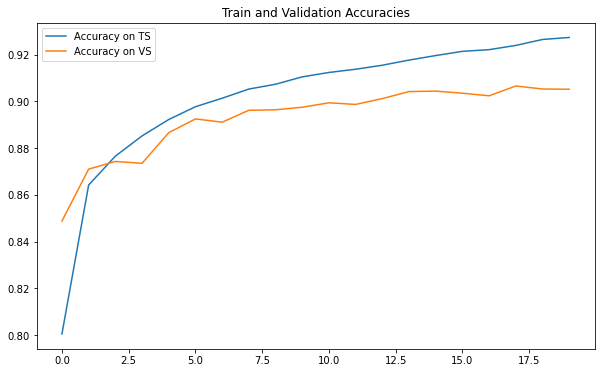

In [20]:
plot_accuracy(history)

### Second CNN
The first model performs already really well, even if we can clearly see some hints of overfitting.
To regularize our model, we decided to use a dropout layer. 

Adding a **dropout layer** individual units of our network are either dropped out of the net with probability $p$ or kept with probability $1-p$, so that a reduced network is left. Incoming and outgoing edges to a dropped-out node are also removed. This helps to achieve a simpler model and to prevent overfitting. The only parameter to specify for a Dropout layer is the probability $p$ to drop a single unit, and we set it to $0.2$.

In [21]:
##### Second Neural Network - One Convolutional layer (with pooling), Dropout and a single dense final layer ####

def model2(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(filters=16,
               kernel_size=(3, 3), 
               name='conv0', 
               padding='same', #'same' preserve the dimension of input through the convolutions
               activation='relu')(X_input) 
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='model2')

    return model

input_shape=(28,28,1)  
model2 = model2(input_shape)

model2.compile(optimizer = "adam", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model2.summary()

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                31370     
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
________________________________________________________

In [22]:
history = model2.fit(x = x_train_sc, y = y_train_sc, epochs = 20, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/20
391/391 [==============================] - 2s 5ms/step - loss: 0.6301 - accuracy: 0.7882 - val_loss: 0.4347 - val_accuracy: 0.8527
Epoch 2/20
391/391 [==============================] - 2s 4ms/step - loss: 0.4025 - accuracy: 0.8601 - val_loss: 0.3791 - val_accuracy: 0.8691
Epoch 3/20
391/391 [==============================] - 2s 4ms/step - loss: 0.3601 - accuracy: 0.8743 - val_loss: 0.3429 - val_accuracy: 0.8797
Epoch 4/20
391/391 [==============================] - 2s 4ms/step - loss: 0.3357 - accuracy: 0.8834 - val_loss: 0.3233 - val_accuracy: 0.8861
Epoch 5/20
391/391 [==============================] - 2s 5ms/step - loss: 0.3157 - accuracy: 0.8898 - val_loss: 0.3146 - val_accuracy: 0.8871
Epoch 6/20
391/391 [==============================] - 2s 5ms/step - loss: 0.3044 - accuracy: 0.8918 - val_loss: 0.3041 - val_accuracy: 0.8910
Epoch 7/20
391/391 [==============================] - 2s 5ms/step - loss: 0.2953 - accuracy: 0.8946 - val_loss: 0.2970 - val_accuracy: 0.8916
Epoch 

In [23]:
# We see the performances of the model
info = model2.evaluate(x_valid_sc, y_valid_sc, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal Accuracy on Validation Set: {}".format(info[0], info[1]))


Final Loss on Validation Set: 0.26259085536003113; 
Final Accuracy on Validation Set: 0.9067000150680542


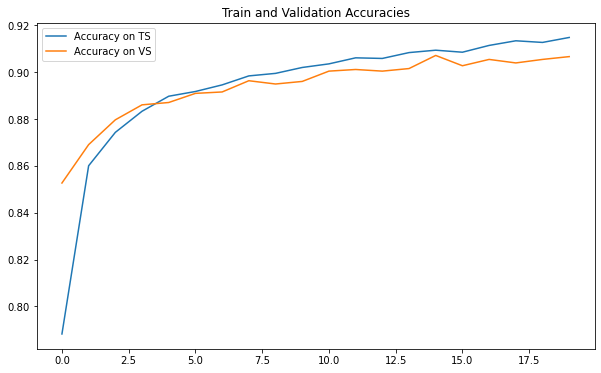

In [24]:
plot_accuracy(history)

### Final CNN

We can see that the performance slightly increased, and the overfitting issue almost disappeared. So finally, as an attempt to get even better results, we tried to test a deeper model, always using the dropout technique.

We also tried to get inspiration from other famous CNNs to see which kind of architectures work best. 
(One example is the following: Karen Simonyan, Andrew Zisserman - _Very Deep Convolutional Networks for Large-Scale Image Recognition_ , 2015 https://arxiv.org/abs/1409.1556 )

The final architecture we chose is the following:

 - Convolutional Layer (16 units) + $ReLu$;
 - Convolutional Layer (16 units) + $ReLu$;
 - MaxPooling, size (2,2), stride 2;
 - Dropout Layer ($p=0.2$);
 - Convolutional Layer (32 units) + $ReLu$;
 - Convolutional Layer (32 units) + $ReLu$;
 - MaxPooling, size (2,2), stride 2;
 - Dropout Layer ($p=0.2$);
 - Dense Output Layer + Softmax.
 
We also kept the same kernel size as before.


In [25]:
##### Final CNN  ####

def model_final(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=16,
               kernel_size=(3, 3), 
               name='conv00', 
               padding='same',
               activation='relu')(X_input)
    X = Conv2D(filters=16,
               kernel_size=(3, 3), 
               name='conv01', 
               padding='same',
               activation='relu')(X)
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               name='conv10', 
               padding='same',
               activation='relu')(X)
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               name='conv011', 
               padding='same',
               activation='relu')(X)
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='model_final')

    return model

input_shape=(28,28,1)  
model_final = model_final(input_shape)

model_final.compile(optimizer ="adam", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model_final.summary()

Model: "model_final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv00 (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv01 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv10 (Conv2D)              (None, 14, 14, 32)        4640      
_________________________________________________________________
conv011 (Conv2D)             (None, 14, 14, 32)        

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [69]:
history = model_final.fit(x = x_train_sc, y = y_train_sc, epochs = 25, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/25
391/391 [==============================] - 3s 8ms/step - loss: 0.6579 - accuracy: 0.7598 - val_loss: 0.4003 - val_accuracy: 0.8558
Epoch 2/25
391/391 [==============================] - 3s 8ms/step - loss: 0.3945 - accuracy: 0.8580 - val_loss: 0.3336 - val_accuracy: 0.8816
Epoch 3/25
391/391 [==============================] - 3s 8ms/step - loss: 0.3447 - accuracy: 0.8755 - val_loss: 0.2996 - val_accuracy: 0.8917
Epoch 4/25
391/391 [==============================] - 3s 8ms/step - loss: 0.3082 - accuracy: 0.8894 - val_loss: 0.2833 - val_accuracy: 0.8965
Epoch 5/25
391/391 [==============================] - 3s 8ms/step - loss: 0.2875 - accuracy: 0.8973 - val_loss: 0.2600 - val_accuracy: 0.9046
Epoch 6/25
391/391 [==============================] - 3s 8ms/step - loss: 0.2702 - accuracy: 0.9027 - val_loss: 0.2545 - val_accuracy: 0.9069
Epoch 7/25
391/391 [==============================] - 3s 8ms/step - loss: 0.2558 - accuracy: 0.9076 - val_loss: 0.2445 - val_accuracy: 0.9111
Epoch 

In [ ]:
# to LOAD the model from disk 
model_final = tf.keras.models.load_model('data/cnn5.h5')

### Model evaluation

Like before, we plot the training and validation accuracies. We see that we obtained a substaintially better result with a final accuracy on the training set of 92.84%.

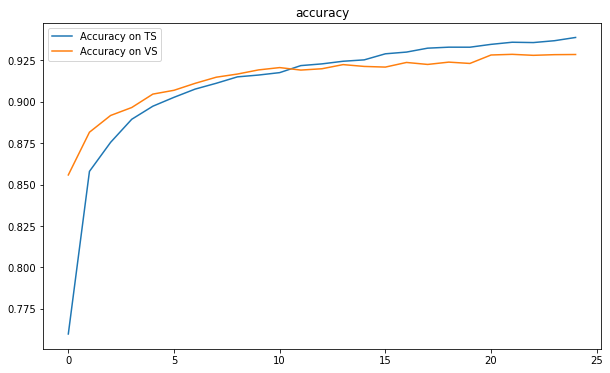

In [70]:
plot_accuracy(history)

In [71]:
model_final.evaluate(x_valid_sc, y_valid_sc, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.1944 - accuracy: 0.9285


[0.1943548172712326, 0.9284999966621399]

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [72]:
x_test_reshaped = x_test_sc.reshape(x_test_sc.shape[0],28,28,1)
y_predictions_softmax = model_final.predict(x_test_reshaped)

In [73]:
# our network predictions are in the format of a 10 component vector, which is the output of the softmax function.
# We need to take the argmax of those vectors!

y_predictions_cnn = np.argmax(y_predictions_softmax, axis = 1)
print(y_predictions_cnn.shape)

(10000,)


In [74]:
# save that on a .csv file for the submission
predictions_cnn_file = pd.DataFrame(y_predictions_cnn)
predictions_cnn_file = predictions_cnn_file.to_csv('y_predictions_cnn.csv', sep=',',index=False)

# Model - Support Vector Machine

Support Vector Machines are powerful models that implement large margin linear classifiers. They inherently support only binary classification, but here we use the scikit-learn implementation of SVM, which supports also multiclass classification by using the "one vs one" scheme. So here we are building one classifier for each distinct couple of features (that means $\frac{(k)(k-1)}{2}$ classifiers, where $k$ is the number of features).

In [48]:
from sklearn.svm import SVC

### Pre-processing

In [49]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 10000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:size]/255
x_test_sc =x_test/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:size]

### Model estimation

Also in this case, to choose the best model, we perform a grid search on different parameters.
We know that SVM uses the "kernel trick", which consists in mapping the original data in higher dimentional spaces, in such a way that they become linearly separable and so that a separating hyperplane can be found. SVM supports a wide variety of kernels, here we use the RBF kernel which is one of the most commonly used.

We make a grid search on two main parameters: 

 - **C**: is the inverse of the regularization parameter;
 - **gamma**: parameter for the RBF kernel. Too small values of gamma yield to too much simplistic models and thus lead to underfitting.
 
Those two parameters influence a lot the performance of SVM so we make a grid search on a fairly big grid. For this reason this step is really time consuming, and we chose to perform it only on a subset of 10000 elements of the training set.
 


In [50]:
##### Define the grid for the grid search
Cs = np.power(2, np.asarray(list(range(4)))).tolist() # C = regularization parameter
gammas = np.power(1/2, np.asarray(list(range(6)))).tolist()[3:] # gamma: parameter for the RBF kernel

param_grid = [
    {'C': Cs, 'gamma': gammas, 'kernel': ['rbf']},
]

# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
print(param_grid)

[{'C': [1, 2, 4, 8], 'gamma': [0.125, 0.0625, 0.03125], 'kernel': ['rbf']}]


<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [15]:
##################################################
# Implement you model here
##################################################

svc = SVC()
# grid search con 5 fold cross validation
clf = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)
clf.fit(x_train_sc, y_train_sc)

print(clf.best_params_)
print("Cross Validation Accuracy: %f" % clf.best_score_)

{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}
Cross Validation Accuracy: 0.872500


The size of the full output file (.sav) is too big to be sent or uploaded, so we converted it in a Dataframe and then we saved it as a .csv file: 

In [51]:
#load the grid search results:
results_grid_search_svm=pd.read_csv('data/results_grid_search_svm.csv')
results_grid_search_svm.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_svm.head()

,params,mean_test_score,rank_test_score
8,"{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}",0.8724,1
11,"{'C': 8, 'gamma': 0.03125, 'kernel': 'rbf'}",0.8718,2
5,"{'C': 2, 'gamma': 0.03125, 'kernel': 'rbf'}",0.8714,3
2,"{'C': 1, 'gamma': 0.03125, 'kernel': 'rbf'}",0.8669,4
4,"{'C': 2, 'gamma': 0.0625, 'kernel': 'rbf'}",0.8604,5


## Train a single model with the best params with all the TS

After we found the two best parameters, we use them to train a final full model on the whole training set.

In [52]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 50000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:size]/255
x_test_sc =x_test/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:size]

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [59]:
svm_final = SVC(C=4, gamma=0.03125, kernel='rbf')
svm_final.fit(x_train_sc, y_train_sc)

SVC(C=4, gamma=0.03125)

### Model evaluation

In [62]:
svm_final.score(x_valid_sc, y_valid_sc)

0.9039

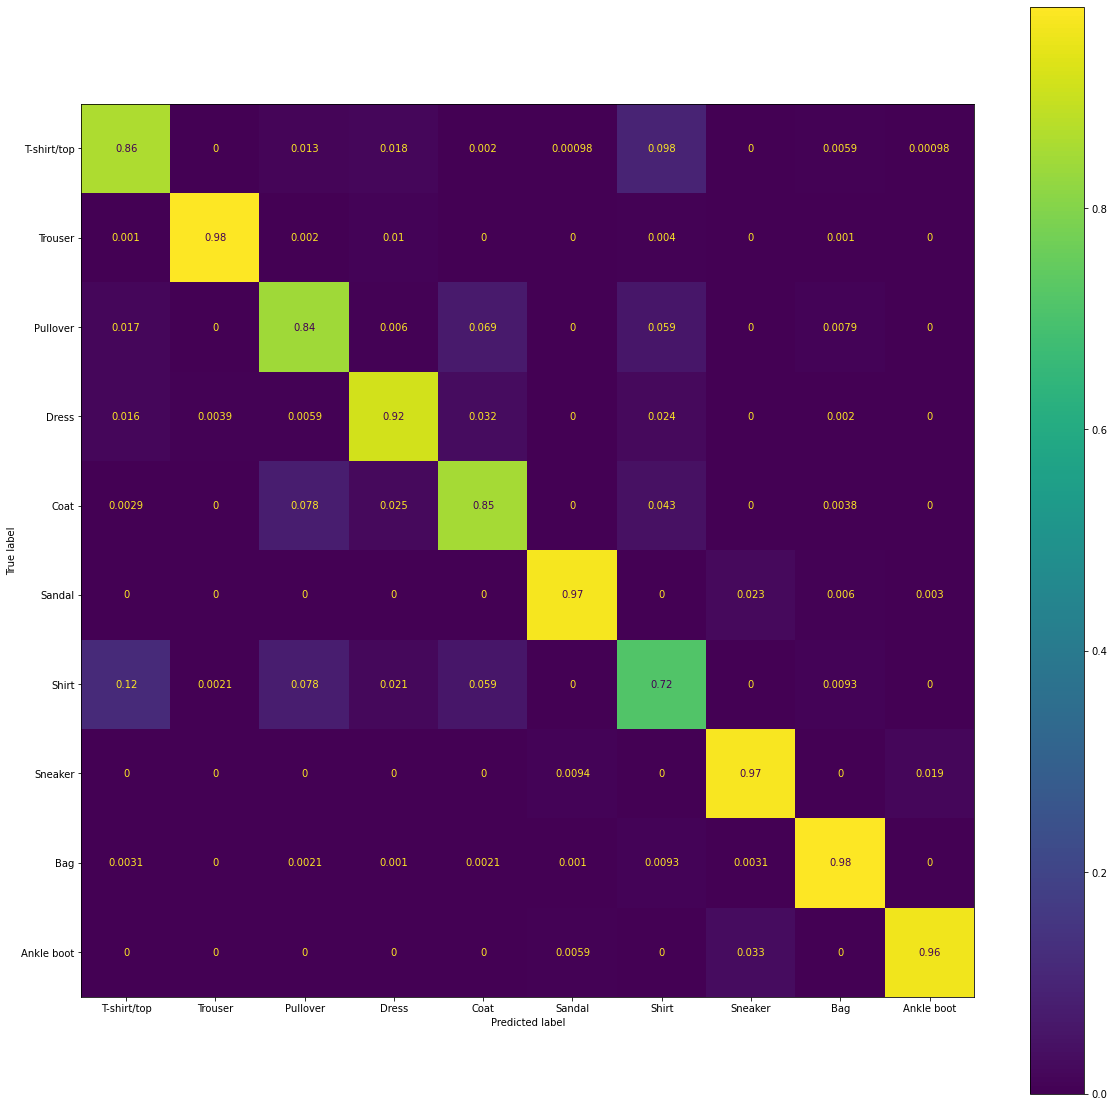

In [26]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(svm_final, x_valid_sc, y_valid_sc,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)  
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown labels in the test set: 

In [27]:
y_pred_svm=svm_final.predict(x_test_sc)

In [28]:
# save that on a .csv file for the submission
predictions_svm_file=pd.DataFrame(y_pred_svm)
predictions_svm_file =predictions_svm_file.to_csv('data/y_predictions_svm.csv', sep=',',index=False)